## Installing torchfusion and importing other goodies


In [0]:
!pip install torchfusion 

In [0]:
from torchfusion.gan.learners import *
from torchfusion.gan.applications import StandardGenerator,StandardProjectionDiscriminator
from torch.optim import Adam
from torchfusion.datasets import mnist_loader
import torch.cuda as cuda
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image 
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch
from numpy import moveaxis
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
from IPython.display import clear_output
ROOT = "/content/drive/My Drive/kaggle/mind_the_bend/"

In [0]:
# copy tar files from google drive to runtime
!cp  /content/drive/"My Drive"/kaggle/mind_the_bend/new_vertices.tar.gz /content/ 
!cp  /content/drive/"My Drive"/kaggle/mind_the_bend/new_vertices_test.tar.gz /content/ 

In [0]:
# make new dirs in runtime and unzip
!mkdir raw_images
!tar -xf /content/new_vertices.tar.gz -C /content/raw_images

!mkdir raw_images_test
!tar -xf /content/new_vertices_test.tar.gz -C /content/raw_images_test

mkdir: cannot create directory ‘raw_images’: File exists
mkdir: cannot create directory ‘raw_images_test’: File exists


In [0]:
def img_to_arr(im_path):
    img = Image.open(im_path)
    x = np.array(img)
    return x
class MyDataset(Dataset):

    def __init__(self, image_folder_path, csv_file_path , transform = None):

        print("Loading CSV from:  ", csv_file_path)
        print("Loading images from:  ", image_folder_path)

        self.transform = transform
        self.labels = pd.read_csv(csv_file_path, header= None)
        self.label = []
        self.img = []

        for i in tqdm(self.labels.values):

            filename = i[0]
            full_path = image_folder_path + filename
            label_y = i[1]
            image_np_array = img_to_arr(full_path)
            self.label.append(label_y)
            self.img.append(image_np_array)

        self.label = np.array(self.label)
        self.img = np.array(self.img)

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)
write_gif(dataset, 'rgbbgr.gif', fps=5)
        return img, torch.tensor([label])

    def __len__(self):
        return len(self.label)

In [0]:
train_set = MyDataset("/content/raw_images/", ROOT + "balanced_labels.csv", 
              transform =transforms.Compose([          
                                                transforms.ToPILImage(),
                                                torchvision.transforms.Resize(size = (64, 64), interpolation=2),
                                                torchvision.transforms.RandomAffine(degrees = 7, translate= (0.09, 0.09), scale=None, shear=None, resample=False, fillcolor = (157, 134, 100)),
                                                ToTensor()
                                           ])
              )

Loading CSV from:   /content/drive/My Drive/kaggle/mind_the_bend/balanced_labels.csv
Loading images from:   /content/raw_images/


In [0]:
train_batch_size = 32
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True, num_workers = 2)

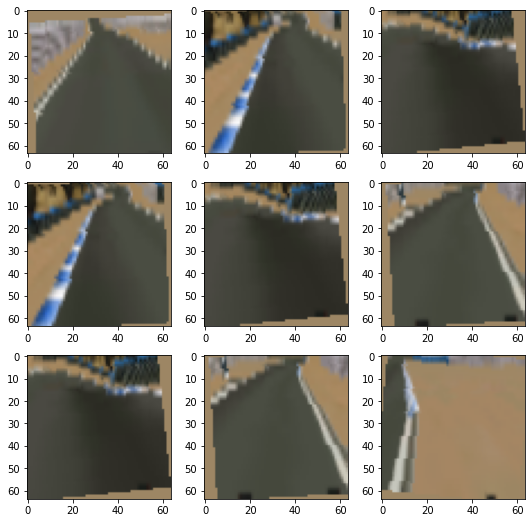

In [0]:
sample = next(iter(train_loader))
image_batch, labels = sample

fig, ax = plt.subplots(3,3, figsize = (9,9))

for i in range (3):
    for j in range(3):
    
        image_np = image_batch[i+j].squeeze(0).numpy()
        image_mvaxis = moveaxis(image_np, 0,2)
        plt.imshow(image_mvaxis)
        
        ax[i,j].imshow(image_mvaxis)

## Using the `StandardGenerator()` and the `StandardProjectionDiscriminator()` 

* `output_size = (color_channels, width, height )` - sets the dimensions of the output image. Set `color_channels = 3 ` for RGB images
* `latent_size` is the number of input channels which act as the "seed" for the generator.
* Make sure the output size of the generator is the same as the input size of the generator 

In [0]:
generated_image_size = (3, 64, 64)
latent_size =128
G = StandardGenerator(output_size= generated_image_size  ,latent_size= latent_size)
D = StandardProjectionDiscriminator(input_size=  generated_image_size ,apply_sigmoid=False)
print(G)
print(D)

StandardGenerator(
  (layers): ModuleList(
    (0): StandardGeneratorBlock(
      (activation): LeakyReLU(negative_slope=0.2)
      (conv): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): StandardGeneratorBlock(
      (activation): LeakyReLU(negative_slope=0.2)
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0, inplace=False)
    (3): StandardGeneratorBlock(
      (activation): LeakyReLU(negative_slope=0.2)
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Dropout(p=0, inplace=False)
    (5): StandardGeneratorBlock(
      (activation): LeakyReLU(negative_slope=0.

## Defining the optimizers 

* increase `num_epochs` for better results
* A smaller latent size gave worse results.

In [0]:
if cuda.is_available():
    G = nn.DataParallel(G.cuda())
    D = nn.DataParallel(D.cuda())

# optimizers
g_optim = Adam(G.parameters(),lr=0.00015,betas=(0.5,0.999))
d_optim = Adam(D.parameters(),lr=0.00015,betas=(0.5,0.999))

g_optim_scheduler = ReduceLROnPlateau(g_optim, mode='min', factor=0.5, patience=2, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
learner = RStandardGanLearner(G,D)


Epoch 1 of 3


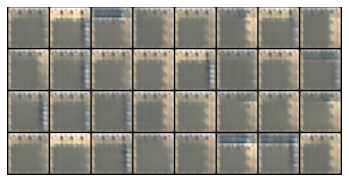

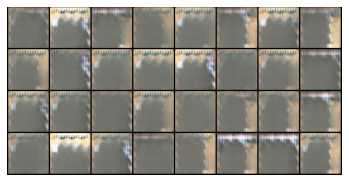


New Generator model saved at ./mind-the-bend-exp/gen_models/gen_model_1.pth
New Discriminator model saved at ./mind-the-bend-exp/disc_models/disc_model_1.pth
Epoch: 1, Duration: 254.84183716773987 , Gen Loss: 4.65447541054203 Disc Loss: 0.0808375178535542


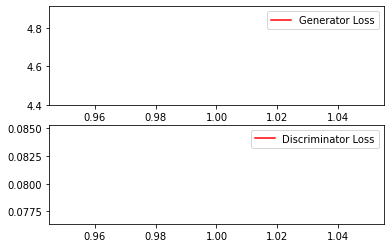

Epoch 2 of 3


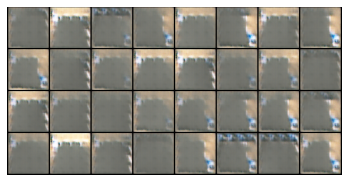

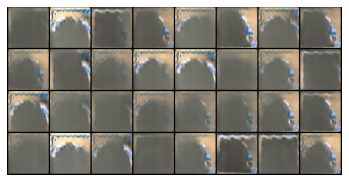


New Generator model saved at ./mind-the-bend-exp/gen_models/gen_model_2.pth
New Discriminator model saved at ./mind-the-bend-exp/disc_models/disc_model_2.pth
Epoch: 2, Duration: 252.87000131607056 , Gen Loss: 5.5357569009818555 Disc Loss: 0.04276797461520656


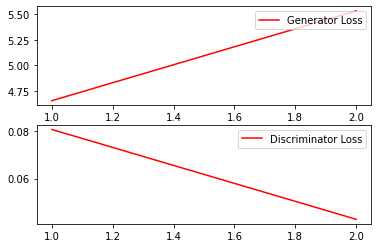

Epoch 3 of 3


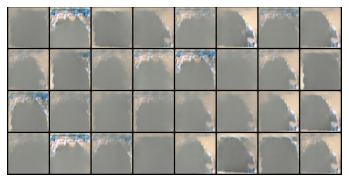

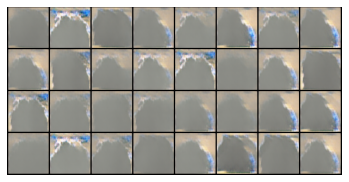


New Generator model saved at ./mind-the-bend-exp/gen_models/gen_model_3.pth
New Discriminator model saved at ./mind-the-bend-exp/disc_models/disc_model_3.pth
Epoch: 3, Duration: 253.59059405326843 , Gen Loss: 6.465139365382407 Disc Loss: 0.029741826055243743


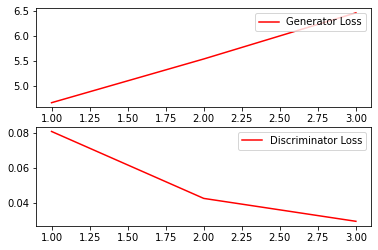

In [0]:
learner.train(train_loader,gen_optimizer=g_optim,disc_optimizer=d_optim,save_outputs_interval=500,model_dir="./mind-the-bend-exp",latent_size= 128,num_epochs=3,batch_log=True, display_metrics = True, notebook_mode = True, gen_lr_scheduler = g_optim_scheduler)

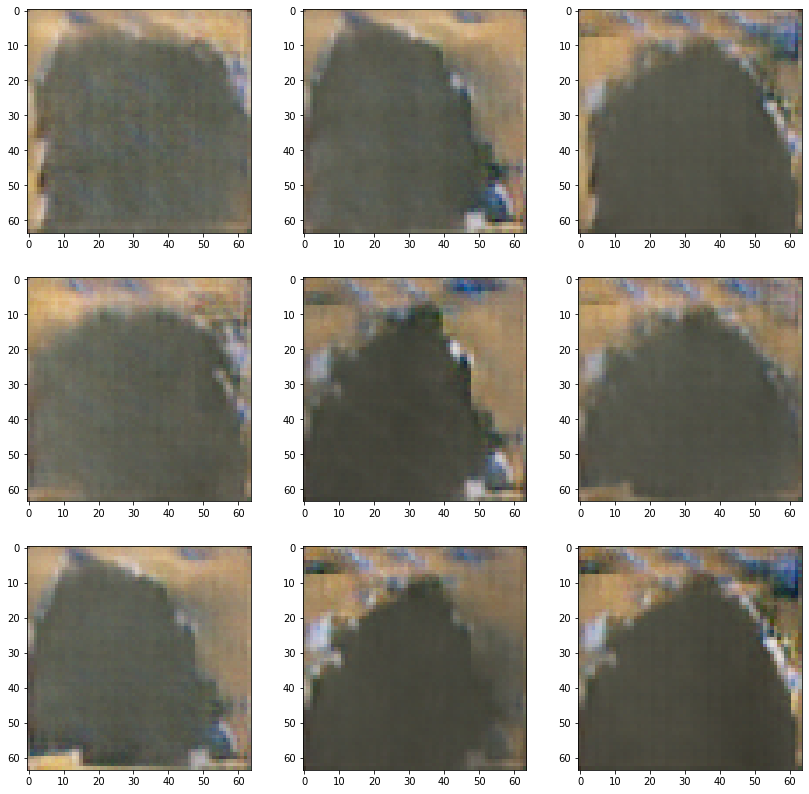

In [118]:
fig, ax = plt.subplots(3,3, figsize = (14,14))       
for i in range(3):
    for j in range(3):
        random_inp = torch.randn([1,128,1,1])
        output = G(random_inp)
        output = torch.clamp(output, min = 0, max = 255 , out=None)
        np_img = moveaxis(output.squeeze(0).detach().cpu().numpy(),0,2)
        # print(np_img.shape)
        # np_img = cv2.resize(np_img, (80,25))
        ax[i,j].imshow(np_img)

## Creating an interpolation with rolling values in the latent space 

In [0]:
!rm -rf images

In [0]:
random_inp = torch.randn([1,128,1,1])
images = []
p = 0
!mkdir images
for p in range(1000):
    random_inp = torch.roll(random_inp, p, dims = 1)
    output = G(random_inp)
    output = torch.clamp(output, min = 0, max = 255 , out=None)
    np_img = moveaxis(output.squeeze(0).detach().cpu().numpy(),0,2)
    plt.imsave( "images/" + str(p) + ".png", np_img)

In [235]:
names = [ "images/" + str(i) + ".png" for i in range (1000)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

10000


In [0]:
images[0].save('interpolation.gif',
               save_all=True,
               append_images=images[1:],
               duration=1000,
               loop=0)